In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning Engineering Nanodegree
## Project: Onde devo gastar o meu dinheiro?

## Criando bases de dados

O objetivo é criar duas tabelas: a primeira contendo dados do crescimento do IFDM de 2012 em relação a 2008, população das cidades e gastos das cidades em cada uma das subáreas e a segunda tabela contendo os valores de gastos de 2009 a 2012 e os valores de IFDM brutos de 2009 a 2012.

In [2]:
# Importando metodos e pacotes

import numpy as np
import pandas as pd

from scipy import stats
from IPython.display import display

from sklearn.decomposition import PCA

import visuals as vs
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix

from sets import Set

/home/allan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: the sets module is deprecated


In [3]:
# Importando bases de dados

# Gastos por funcao no ano de 2009 a 2012
gastos_2012 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2012.csv", encoding="utf-8")
gastos_2011 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2011.csv", encoding="utf-8")
gastos_2010 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2010.csv", encoding="utf-8")
gastos_2009 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2009.csv", encoding="utf-8")

# Codigos de identificacao dos estados e municipios
codigo_municipio = pd.read_csv("Data/Codigo municipal/CodMun2012.csv", encoding='utf-8')
codigo_estado = pd.read_csv("Data/Codigo UF/CodUF2012.csv", encoding='utf-8')

# IFDM por categoria de 2005 a 2013
ifdm_geral_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_geral_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_saude_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_saude_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_empregoRenda_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_empregoRenda_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_educacao_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_educacao_2005-2013.csv", encoding="utf_8", sep=";")

# Metricas municipais em 2010 (IDH)
municipios_metricas = pd.read_csv("Data/Municipios/municipios.csv", encoding="utf-8", sep=";", decimal=",")

In [4]:
# Criando uma tabela para consulta de cidade e estado
estado_municipio = pd.merge(codigo_municipio, codigo_estado, how='inner', left_on=["CD_UF"], right_on=["CD_UF"])

In [5]:
# Seleciona apenas cidades em comum nas bases

# Unifica cidade e estado para uma unica coluna
def une_cidade_estado(df):
    uf = df["UF"].astype(str)
    mun = df["Cod Mun"].astype(str)
    df["uf_mun"] = uf+"-"+mun
    return df

def troca_codigo_nome(df):
    gastos_ = df.merge(estado_municipio, how='inner', left_on=["Cod Mun", "UF"], right_on=["CD_MUN", "CD_UF"])
    gastos_.drop(['CD_UF', 'CD_MUN', 'UF_x', 'Cod Mun', 'ESTADO'], axis = 1, inplace = True)
    gastos_.rename(columns={'UF_y':'UF', 'MUNICIPIO':'Municipio'}, inplace=True)
    return gastos_

une_cidade_estado(gastos_2009)
une_cidade_estado(gastos_2010)
une_cidade_estado(gastos_2011)
une_cidade_estado(gastos_2012)

# Transforma em Set e busca as cidades em comum a todas bases
int_09_10 = Set(gastos_2009.uf_mun).intersection(Set(gastos_2010.uf_mun))
int_11_12 = Set(gastos_2011.uf_mun).intersection(Set(gastos_2012.uf_mun))
int_todos = int_09_10.intersection(int_11_12)

# Seleciona as cidades remanescentes para cada base
gastos_2012 = gastos_2012[gastos_2012.uf_mun.isin(int_todos)]
gastos_2011 = gastos_2011[gastos_2011.uf_mun.isin(int_todos)]
gastos_2010 = gastos_2010[gastos_2010.uf_mun.isin(int_todos)]
gastos_2009 = gastos_2009[gastos_2009.uf_mun.isin(int_todos)]

# Ordena gastos de 2009 a 2012
gastos_2012 = gastos_2012.sort_values(["uf_mun"])
gastos_2011 = gastos_2011.sort_values(["uf_mun"])
gastos_2010 = gastos_2010.sort_values(["uf_mun"])
gastos_2009 = gastos_2009.sort_values(["uf_mun"])

# Exclui colunas em excesso
gastos_2012.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2011.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2010.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2009.drop(["uf_mun"], axis = 1, inplace = True)

# Alinha os indices dos data frames
gastos_2011 = gastos_2011.set_index(gastos_2012.index)
gastos_2010 = gastos_2010.set_index(gastos_2012.index)
gastos_2009 = gastos_2009.set_index(gastos_2012.index)

# Troca os codigos dos municipios pelos nomes
gastos_2012 = troca_codigo_nome(gastos_2012)
gastos_2011 = troca_codigo_nome(gastos_2011)
gastos_2010 = troca_codigo_nome(gastos_2010)
gastos_2009 = troca_codigo_nome(gastos_2009)

In [6]:
# Coloca os gastos em porcentagem
def percent(df):
    
    uf_cod_mun = df.loc[:,['UF','Municipio']]

    df = df.drop(['UF','Municipio'], axis=1)
    total_gastos = df.pop('Despesas por Funcao')

    df_percent = df.div(total_gastos, axis=0)

    # Remonta tabela de gastos inicial
    df_mun = pd.concat([df, total_gastos, uf_cod_mun], axis=1)

    # Concatena gastos ao municipio
    df_mun_percent = pd.concat([df_percent, uf_cod_mun], axis=1)
    return df_mun_percent

gastos_2012_percent = percent(gastos_2012)
gastos_2011_percent = percent(gastos_2011)
gastos_2010_percent = percent(gastos_2010)
gastos_2009_percent = percent(gastos_2009)

In [7]:
# Filtra apenas os municipios com metricas mais recentes e busca apenas as colunas de interesse
municipio_populacao = municipios_metricas.loc[municipios_metricas['ANO'] == municipios_metricas['ANO'].max(), ['Municipio','UF','POP']]

# Trocando codigo de estado pelo nome do estado em municipio_ 
municipio_populacao = codigo_estado.merge(municipio_populacao, left_on=["CD_UF"], right_on=["UF"])
municipio_populacao.drop(['CD_UF', 'UF_y', 'ESTADO'], axis = 1, inplace = True)
municipio_populacao.rename(columns={'UF_x':'UF', 'POP':'Populacao'}, inplace=True)

display(municipio_populacao.head())

UF              Municipio  Populacao
0  RO  ALTA FLORESTA D'OESTE      24097
1  RO              ARIQUEMES      89766
2  RO                 CABIXI       6303
3  RO                 CACOAL      78141
4  RO             CEREJEIRAS      16942

In [8]:
# Criando tabela de IFDM 
conditions = ['Codigo','Regiao','UF','Municipio']
ifdm = ifdm_geral_ano_base_2005_2013.merge(ifdm_saude_ano_base_2005_2013,on=conditions).merge(ifdm_empregoRenda_ano_base_2005_2013,on=conditions).merge(ifdm_educacao_ano_base_2005_2013,on=conditions)

# Removendo cidades sem algum valor de IFDM em algum ano
ifdm = ifdm.dropna()

In [9]:
def remove_acentos(df, coluna):
    sem_acentos = df[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df.loc[:,coluna] = sem_acentos
    return df

def letras_minusculas(df, coluna):
    minusculas = df[coluna].str.lower()
    df.loc[:,coluna] = minusculas
    return df

# remove acentos dos nomes das cidades e coloca em letra minuscula
ifdm = remove_acentos(ifdm, "Municipio")
municipio_populacao = remove_acentos(municipio_populacao, "Municipio")

ifdm = letras_minusculas(ifdm, "Municipio")
municipio_populacao = letras_minusculas(municipio_populacao, "Municipio")

### Criando tabela de gastos acumulados de 2009 a 2012 e diferença de IFDM de 2008 a 2012

In [10]:
# Soma os gastos dos anos
mun = gastos_2012.loc[:,["Municipio","UF"]]

gastos_2012_ = gastos_2012.drop(['UF','Municipio'], axis=1)
gastos_2011_ = gastos_2011.drop(['UF','Municipio'], axis=1)
gastos_2010_ = gastos_2010.drop(['UF','Municipio'], axis=1)
gastos_2009_ = gastos_2009.drop(['UF','Municipio'], axis=1)

gastos_09_12 = gastos_2012_.add(gastos_2011_).add(gastos_2010_).add(gastos_2009_)

gastos_09_12 = pd.concat([mun, gastos_09_12], axis=1)

In [11]:
# Cria tabela de porcentagens de gastos pelo total de gastos
gastos_09_12_mun_percent = percent(gastos_09_12)

In [12]:
# remove acentos dos nomes das cidades e coloca em letra minuscula
gastos_09_12_mun_percent = remove_acentos(gastos_09_12_mun_percent, "Municipio")
gastos_09_12_mun_percent = letras_minusculas(gastos_09_12_mun_percent, "Municipio")

In [13]:
# Calcula diferença do IFDM de 2012 e 2008
ifdm['ifdm_dif_saude'] = ifdm['2012_saude_nota'] - ifdm['2008_saude_nota']
ifdm['ifdm_dif_educacao'] = ifdm['2012_educacao_nota'] - ifdm['2008_educacao_nota']
ifdm['ifdm_dif_geral'] = ifdm['2012_geral_nota'] - ifdm['2008_geral_nota']

# Filtra apenas colunas de interesse
ifdm_dif = ifdm[['Municipio','UF','Regiao','ifdm_dif_saude','ifdm_dif_educacao','2012_saude_nota','2012_educacao_nota']]

In [14]:
# Adiciona ifdm_dif a tabela de gastos
gastos_ifdm_dif = ifdm_dif.merge(gastos_09_12_mun_percent, on=["Municipio","UF"])

# Renomeia algumas colunas
gastos_ifdm_dif.rename(columns={'Demais Subfuncoes 10':'Demais Subfuncoes Saude','Demais Subfuncoes 12':'Demais Subfuncoes Educacao'}, inplace=True)

# Filtra features relacionadas a investimentos em trabalho, saude e educacao
gastos_ifdm_dif = gastos_ifdm_dif.loc[:,['ifdm_dif_saude','ifdm_dif_educacao','2012_saude_nota','2012_educacao_nota','Regiao','UF','Municipio','Saude','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude','Educacao','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao']]

In [15]:
# Adiciona populacao a tabela de gastos
gastos_ifdm_dif = gastos_ifdm_dif.merge(municipio_populacao, on=["Municipio","UF"])

In [16]:
# Finalizando primeira tabela: Tabela de gastos acumulados na gestao de 2009-2012

# Categoriza o tamanho das cidades pela populacao
gastos_ifdm_dif['Tamanho'] = np.where(gastos_ifdm_dif['Populacao'] < 50000, 'Pequena', 
        np.where(gastos_ifdm_dif['Populacao'] < 100000, 'Media-pequena',
                np.where(gastos_ifdm_dif['Populacao'] < 300000, 'Media',
                        np.where(gastos_ifdm_dif['Populacao'] < 500000, 'Media-grande',
                                np.where(gastos_ifdm_dif['Populacao'] < 1000000, 'Grande', 'Metropole')))))

In [17]:
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_educacao  2012_saude_nota  2012_educacao_nota  \
0          0.0625             0.0102           0.5759              0.6329   
1          0.0920             0.1406           0.8373              0.7606   
2          0.0371             0.0674           0.6419              0.7462   
3          0.1379             0.0977           0.8258              0.7169   
4          0.0897             0.0443           0.5596              0.7308   

  Regiao  UF              Municipio     Saude  Atencao Basica  \
0  Norte  RO  alta floresta d'oeste  0.273451        0.085496   
1  Norte  RO              ariquemes  0.240095        0.028727   
2  Norte  RO                 cabixi  0.238619        0.062699   
3  Norte  RO                 cacoal  0.260753        0.036536   
4  Norte  RO             cerejeiras  0.245080        0.058779   

   Assistencia Hospitalar      ...        Ensino Fundamental  Ensino Medio  \
0                0.183615      ...                  0.258567      0.000000   
1                0.070513      ...                  0.186091      0.000000   
2                0.169311      ...                  0.272795      0.000000   
3                0.111969      ...                  0.174964      0.000000   
4                0.071014      ...                  0.199923      0.011347   

   Ensino Profissional  Ensino Superior  Educacao Infantil  \
0                  0.0         0.000608           0.009761   
1                  0.0         0.000122           0.012523   
2                  0.0         0.000913           0.020824   
3                  0.0         0.000000           0.040643   
4                  0.0         0.000000           0.022167   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.002224           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000594   
4                      0.000000           0.000992   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.133886      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.016351      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 26 columns]

# Análise descritiva


In [20]:
# Dados
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_educacao  2012_saude_nota  2012_educacao_nota  \
0          0.0625             0.0102           0.5759              0.6329   
1          0.0920             0.1406           0.8373              0.7606   
2          0.0371             0.0674           0.6419              0.7462   
3          0.1379             0.0977           0.8258              0.7169   
4          0.0897             0.0443           0.5596              0.7308   

  Regiao  UF              Municipio     Saude  Atencao Basica  \
0  Norte  RO  alta floresta d'oeste  0.273451        0.085496   
1  Norte  RO              ariquemes  0.240095        0.028727   
2  Norte  RO                 cabixi  0.238619        0.062699   
3  Norte  RO                 cacoal  0.260753        0.036536   
4  Norte  RO             cerejeiras  0.245080        0.058779   

   Assistencia Hospitalar      ...        Ensino Fundamental  Ensino Medio  \
0                0.183615      ...                  0.258567      0.000000   
1                0.070513      ...                  0.186091      0.000000   
2                0.169311      ...                  0.272795      0.000000   
3                0.111969      ...                  0.174964      0.000000   
4                0.071014      ...                  0.199923      0.011347   

   Ensino Profissional  Ensino Superior  Educacao Infantil  \
0                  0.0         0.000608           0.009761   
1                  0.0         0.000122           0.012523   
2                  0.0         0.000913           0.020824   
3                  0.0         0.000000           0.040643   
4                  0.0         0.000000           0.022167   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.002224           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000594   
4                      0.000000           0.000992   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.133886      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.016351      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 26 columns]

In [21]:
# Descricao dos dados pelo tamanho da cidade
#g = gastos_ifdm_dif.groupby('Tamanho')

media = gastos_ifdm_dif[gastos_ifdm_dif.Tamanho == 'Media']

m_describe = np.round(media.describe(), 4).transpose()

display(m_describe)

m_describe.to_csv('descricao_dados.csv')

count         mean         std          min  \
ifdm_dif_saude                184.0       0.0350      0.0488      -0.0761   
ifdm_dif_educacao             184.0       0.0759      0.0348       0.0044   
2012_saude_nota               184.0       0.8074      0.0990       0.4368   
2012_educacao_nota            184.0       0.7747      0.1125       0.5265   
Saude                         184.0       0.2361      0.0619       0.1004   
Atencao Basica                184.0       0.0999      0.0569       0.0000   
Assistencia Hospitalar        184.0       0.0893      0.0671       0.0000   
Suporte Profilatico           184.0       0.0046      0.0092       0.0000   
Vigilancia Sanitaria          184.0       0.0020      0.0028       0.0000   
Vigilancia Epidemiologica     184.0       0.0050      0.0044       0.0000   
Alimentacao e Nutricao        184.0       0.0021      0.0058       0.0000   
Demais Subfuncoes Saude       184.0       0.0333      0.0447       0.0000   
Educacao                      184.0       0.2729      0.0624       0.1445   
Ensino Fundamental            184.0       0.1998      0.0680       0.0746   
Ensino Medio                  184.0       0.0028      0.0163       0.0000   
Ensino Profissional           184.0       0.0014      0.0054       0.0000   
Ensino Superior               184.0       0.0031      0.0095       0.0000   
Educacao Infantil             184.0       0.0450      0.0321       0.0000   
Educacao de Jovens e Adultos  184.0       0.0021      0.0035       0.0000   
Educacao Especial             184.0       0.0016      0.0029       0.0000   
Demais Subfuncoes Educacao    184.0       0.0215      0.0324       0.0000   
Populacao                     184.0  163855.0109  56230.2802  100166.0000   

                                      25%          50%          75%  \
ifdm_dif_saude                     0.0012       0.0280       0.0623   
ifdm_dif_educacao                  0.0520       0.0742       0.0940   
2012_saude_nota                    0.7658       0.8238       0.8787   
2012_educacao_nota                 0.6869       0.7874       0.8646   
Saude                              0.1973       0.2227       0.2703   
Atencao Basica                     0.0605       0.0935       0.1354   
Assistencia Hospitalar             0.0339       0.0868       0.1242   
Suporte Profilatico                0.0000       0.0025       0.0059   
Vigilancia Sanitaria               0.0002       0.0010       0.0027   
Vigilancia Epidemiologica          0.0017       0.0037       0.0079   
Alimentacao e Nutricao             0.0000       0.0000       0.0006   
Demais Subfuncoes Saude            0.0000       0.0162       0.0500   
Educacao                           0.2303       0.2704       0.3043   
Ensino Fundamental                 0.1531       0.1916       0.2395   
Ensino Medio                       0.0000       0.0000       0.0009   
Ensino Profissional                0.0000       0.0000       0.0003   
Ensino Superior                    0.0000       0.0000       0.0015   
Educacao Infantil                  0.0183       0.0394       0.0712   
Educacao de Jovens e Adultos       0.0000       0.0007       0.0025   
Educacao Especial                  0.0000       0.0002       0.0023   
Demais Subfuncoes Educacao         0.0019       0.0112       0.0287   
Populacao                     115784.5000  145899.5000  203775.2500   

                                      max  
ifdm_dif_saude                     0.2117  
ifdm_dif_educacao                  0.2960  
2012_saude_nota                    0.9660  
2012_educacao_nota                 0.9743  
Saude                              0.4209  
Atencao Basica                     0.3203  
Assistencia Hospitalar             0.3238  
Suporte Profilatico                0.0971  
Vigilancia Sanitaria               0.0193  
Vigilancia Epidemiologica          0.0214  
Alimentacao e Nutricao             0.0332  
Demais Subfuncoes Saude            0.2219  
Educacao                           0.4650  
Ensino F

In [22]:
# Utilizacao de cidades medias, media-grandes, grandes e metropoles no estudo
cidades_medias = gastos_ifdm_dif.loc[gastos_ifdm_dif['Tamanho'].isin(['Media'])]
n_cidades = len(cidades_medias)
print "Numero de cidades na base: {}".format(n_cidades)

Numero de cidades na base: 184


In [23]:
print "Cidades por estado: "
c = cidades_medias['UF'].value_counts()
print c

c.to_csv('cidades_por_estado.csv')

Cidades por estado: 
SP    51
MG    17
RJ    15
RS    14
PR    13
BA    11
SC     9
PE     8
CE     6
MA     6
ES     5
PA     5
GO     5
MT     3
MS     3
TO     2
RN     2
PB     2
SE     1
RR     1
PI     1
RO     1
AL     1
AP     1
AM     1
Name: UF, dtype: int64


In [24]:
print "Cidades por regiao: "
r = cidades_medias['Regiao'].value_counts()
print r

r.to_csv("cidades_regiao.csv")

Cidades por regiao: 
Sudeste         88
Nordeste        38
Sul             36
Centro-Oeste    11
Norte           11
Name: Regiao, dtype: int64


In [25]:
# Separa so os gastos de cada cidade
gastos = cidades_medias.copy()
gastos.drop(['ifdm_dif_saude','ifdm_dif_educacao','2012_saude_nota','2012_educacao_nota','Regiao','UF','Municipio','Tamanho','Populacao'], axis = 1, inplace = True)

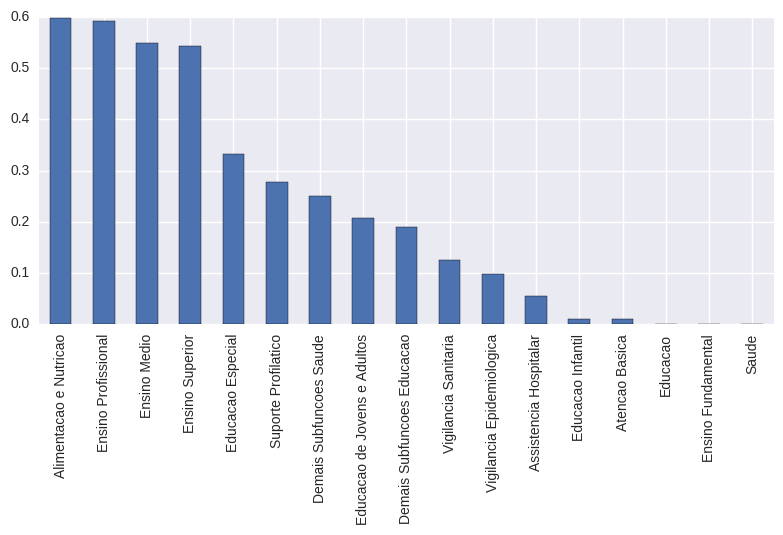

In [26]:
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();
plt.tight_layout()
plt.savefig('Imagens/features_zeros.pdf')

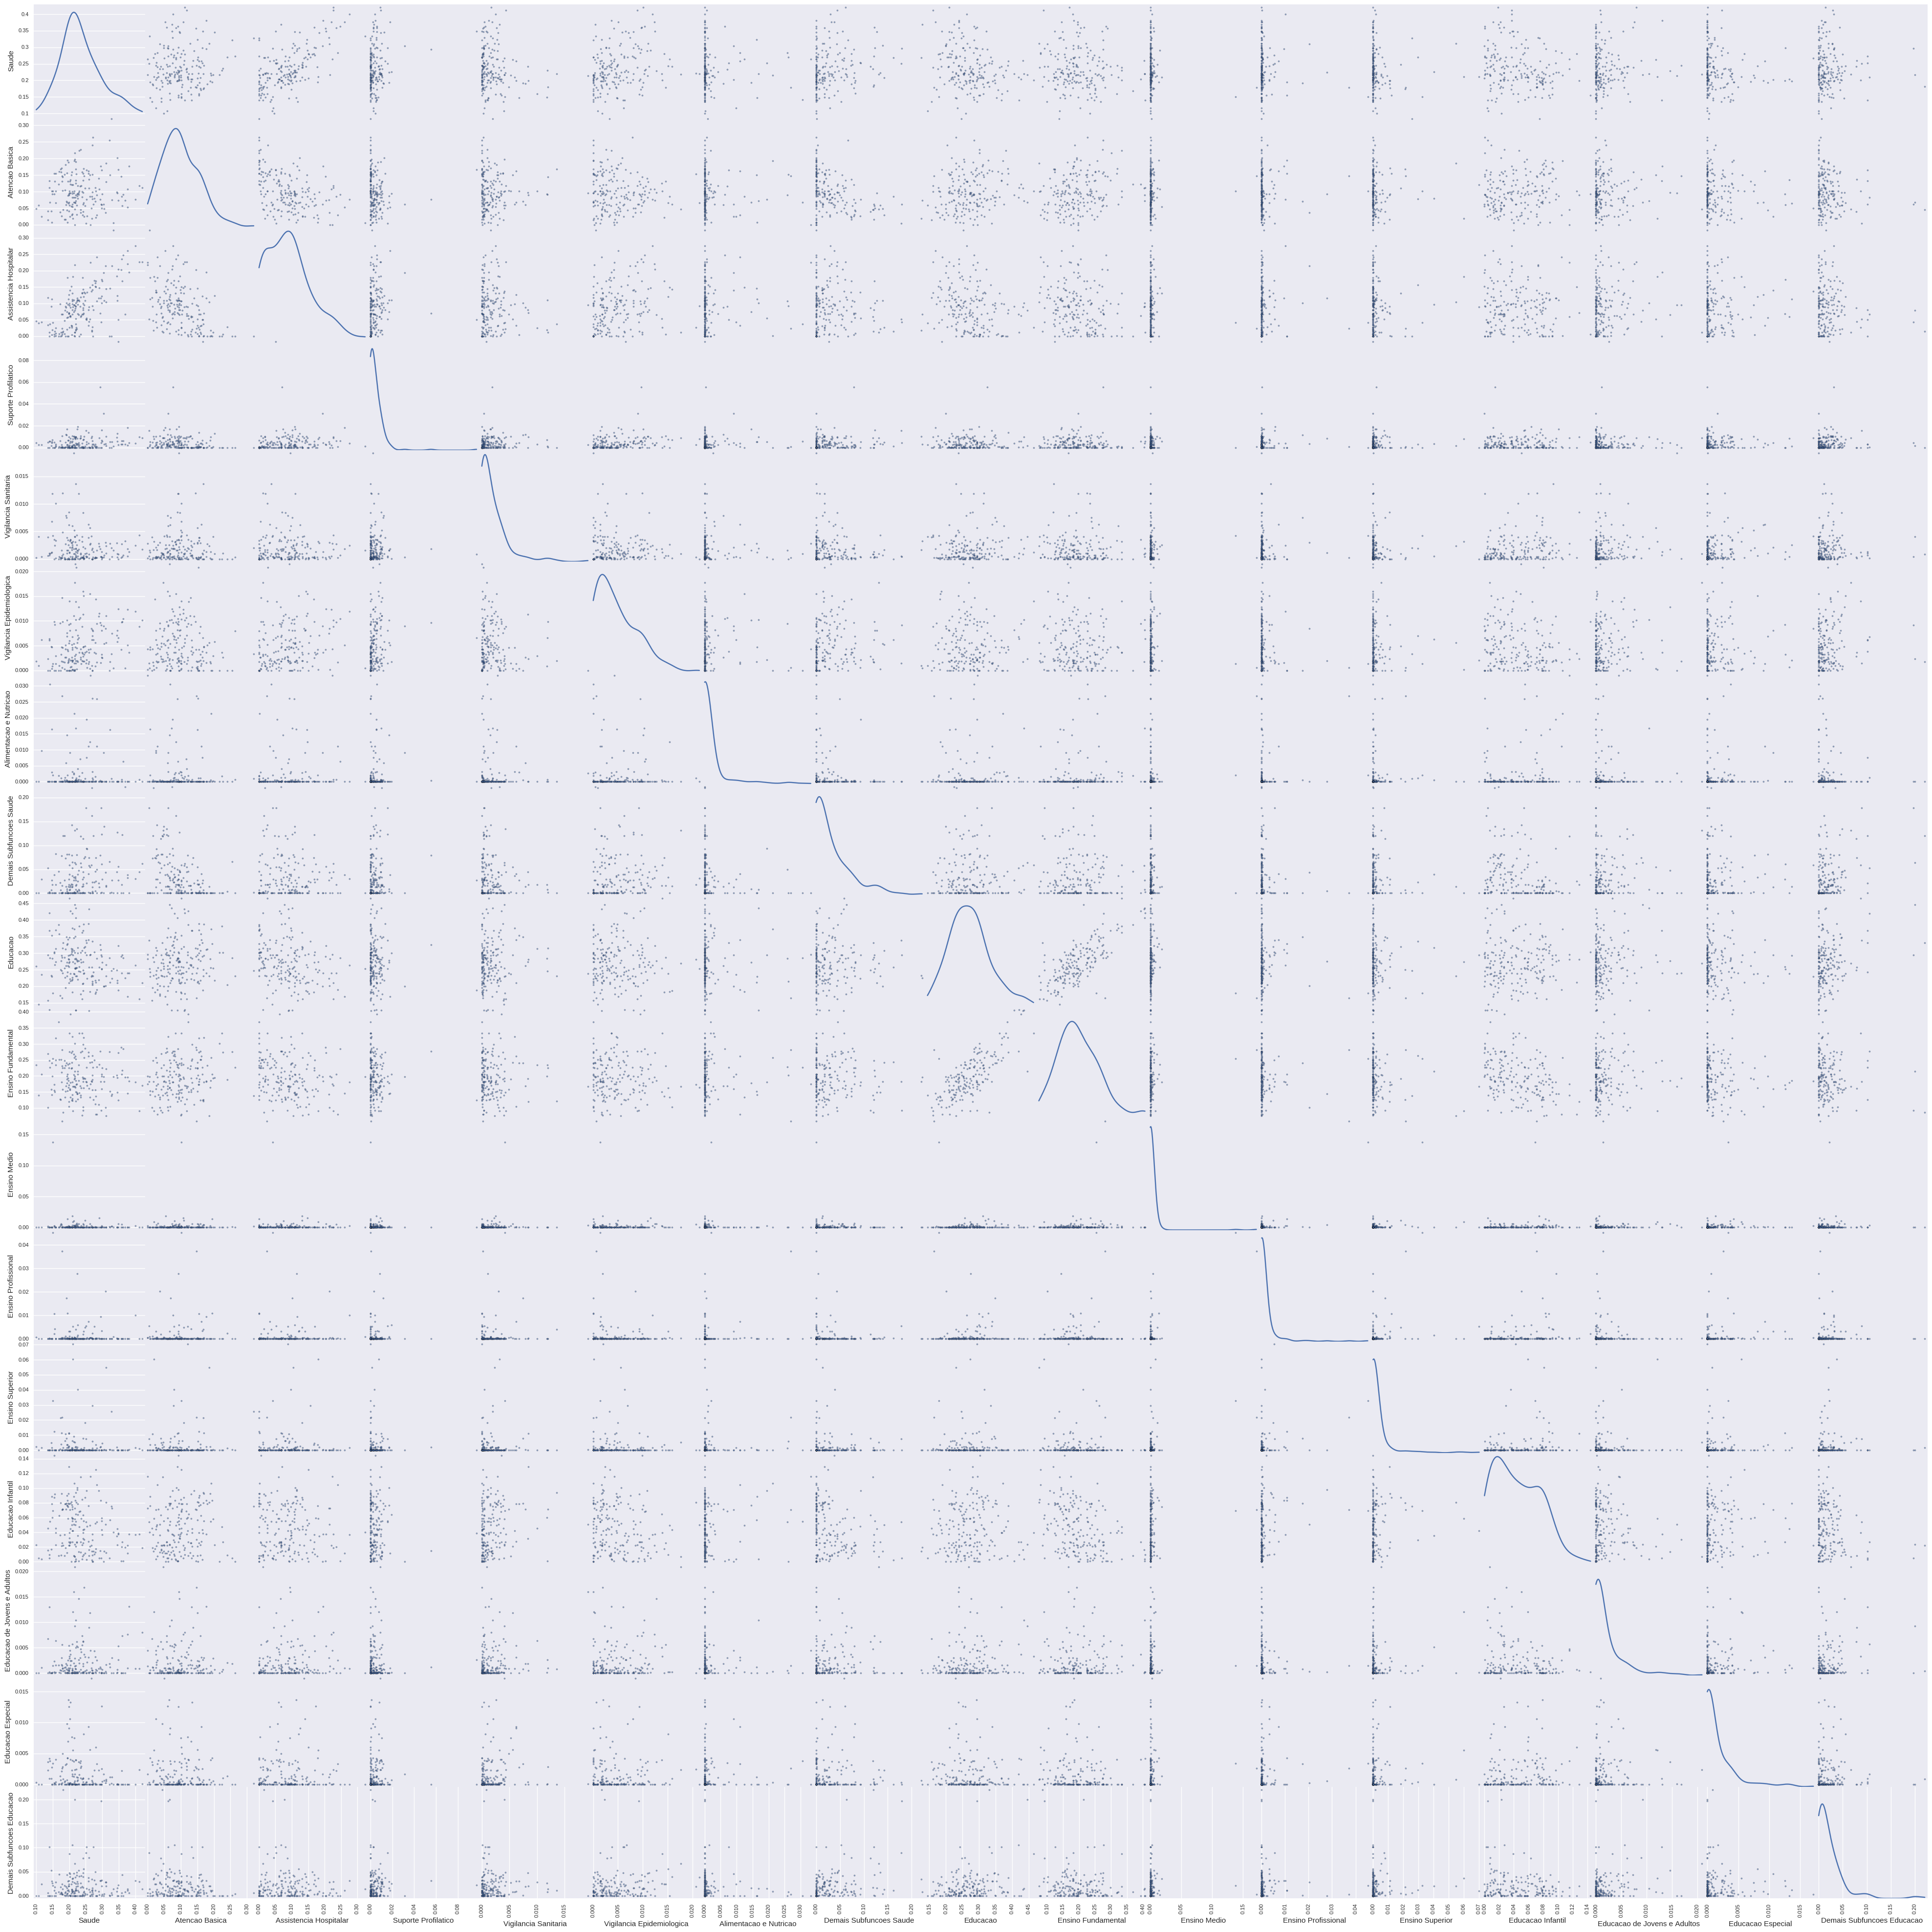

In [27]:
# Produz um scatterplot para cada par de features
scatter_matrix(gastos, figsize=(50, 50), diagonal='kde');
plt.savefig('distribuicaoFeatures.pdf');

## Pré-processamento

In [28]:
# Encontra cidades que nao descreveram os gastos de acordo com o esperado e devem ser removidas da pesquisa
para_remover = (gastos[gastos.Educacao == 0.0].index)
para_remover.append(gastos[gastos.Saude == 0.0].index)
len(para_remover)

0

In [29]:
# Remove cidades das bases utilizadas
cidades_medias = cidades_medias[~cidades_medias.index.isin(para_remover)]
gastos = gastos[~gastos.index.isin(para_remover)]
len(cidades_medias)

184

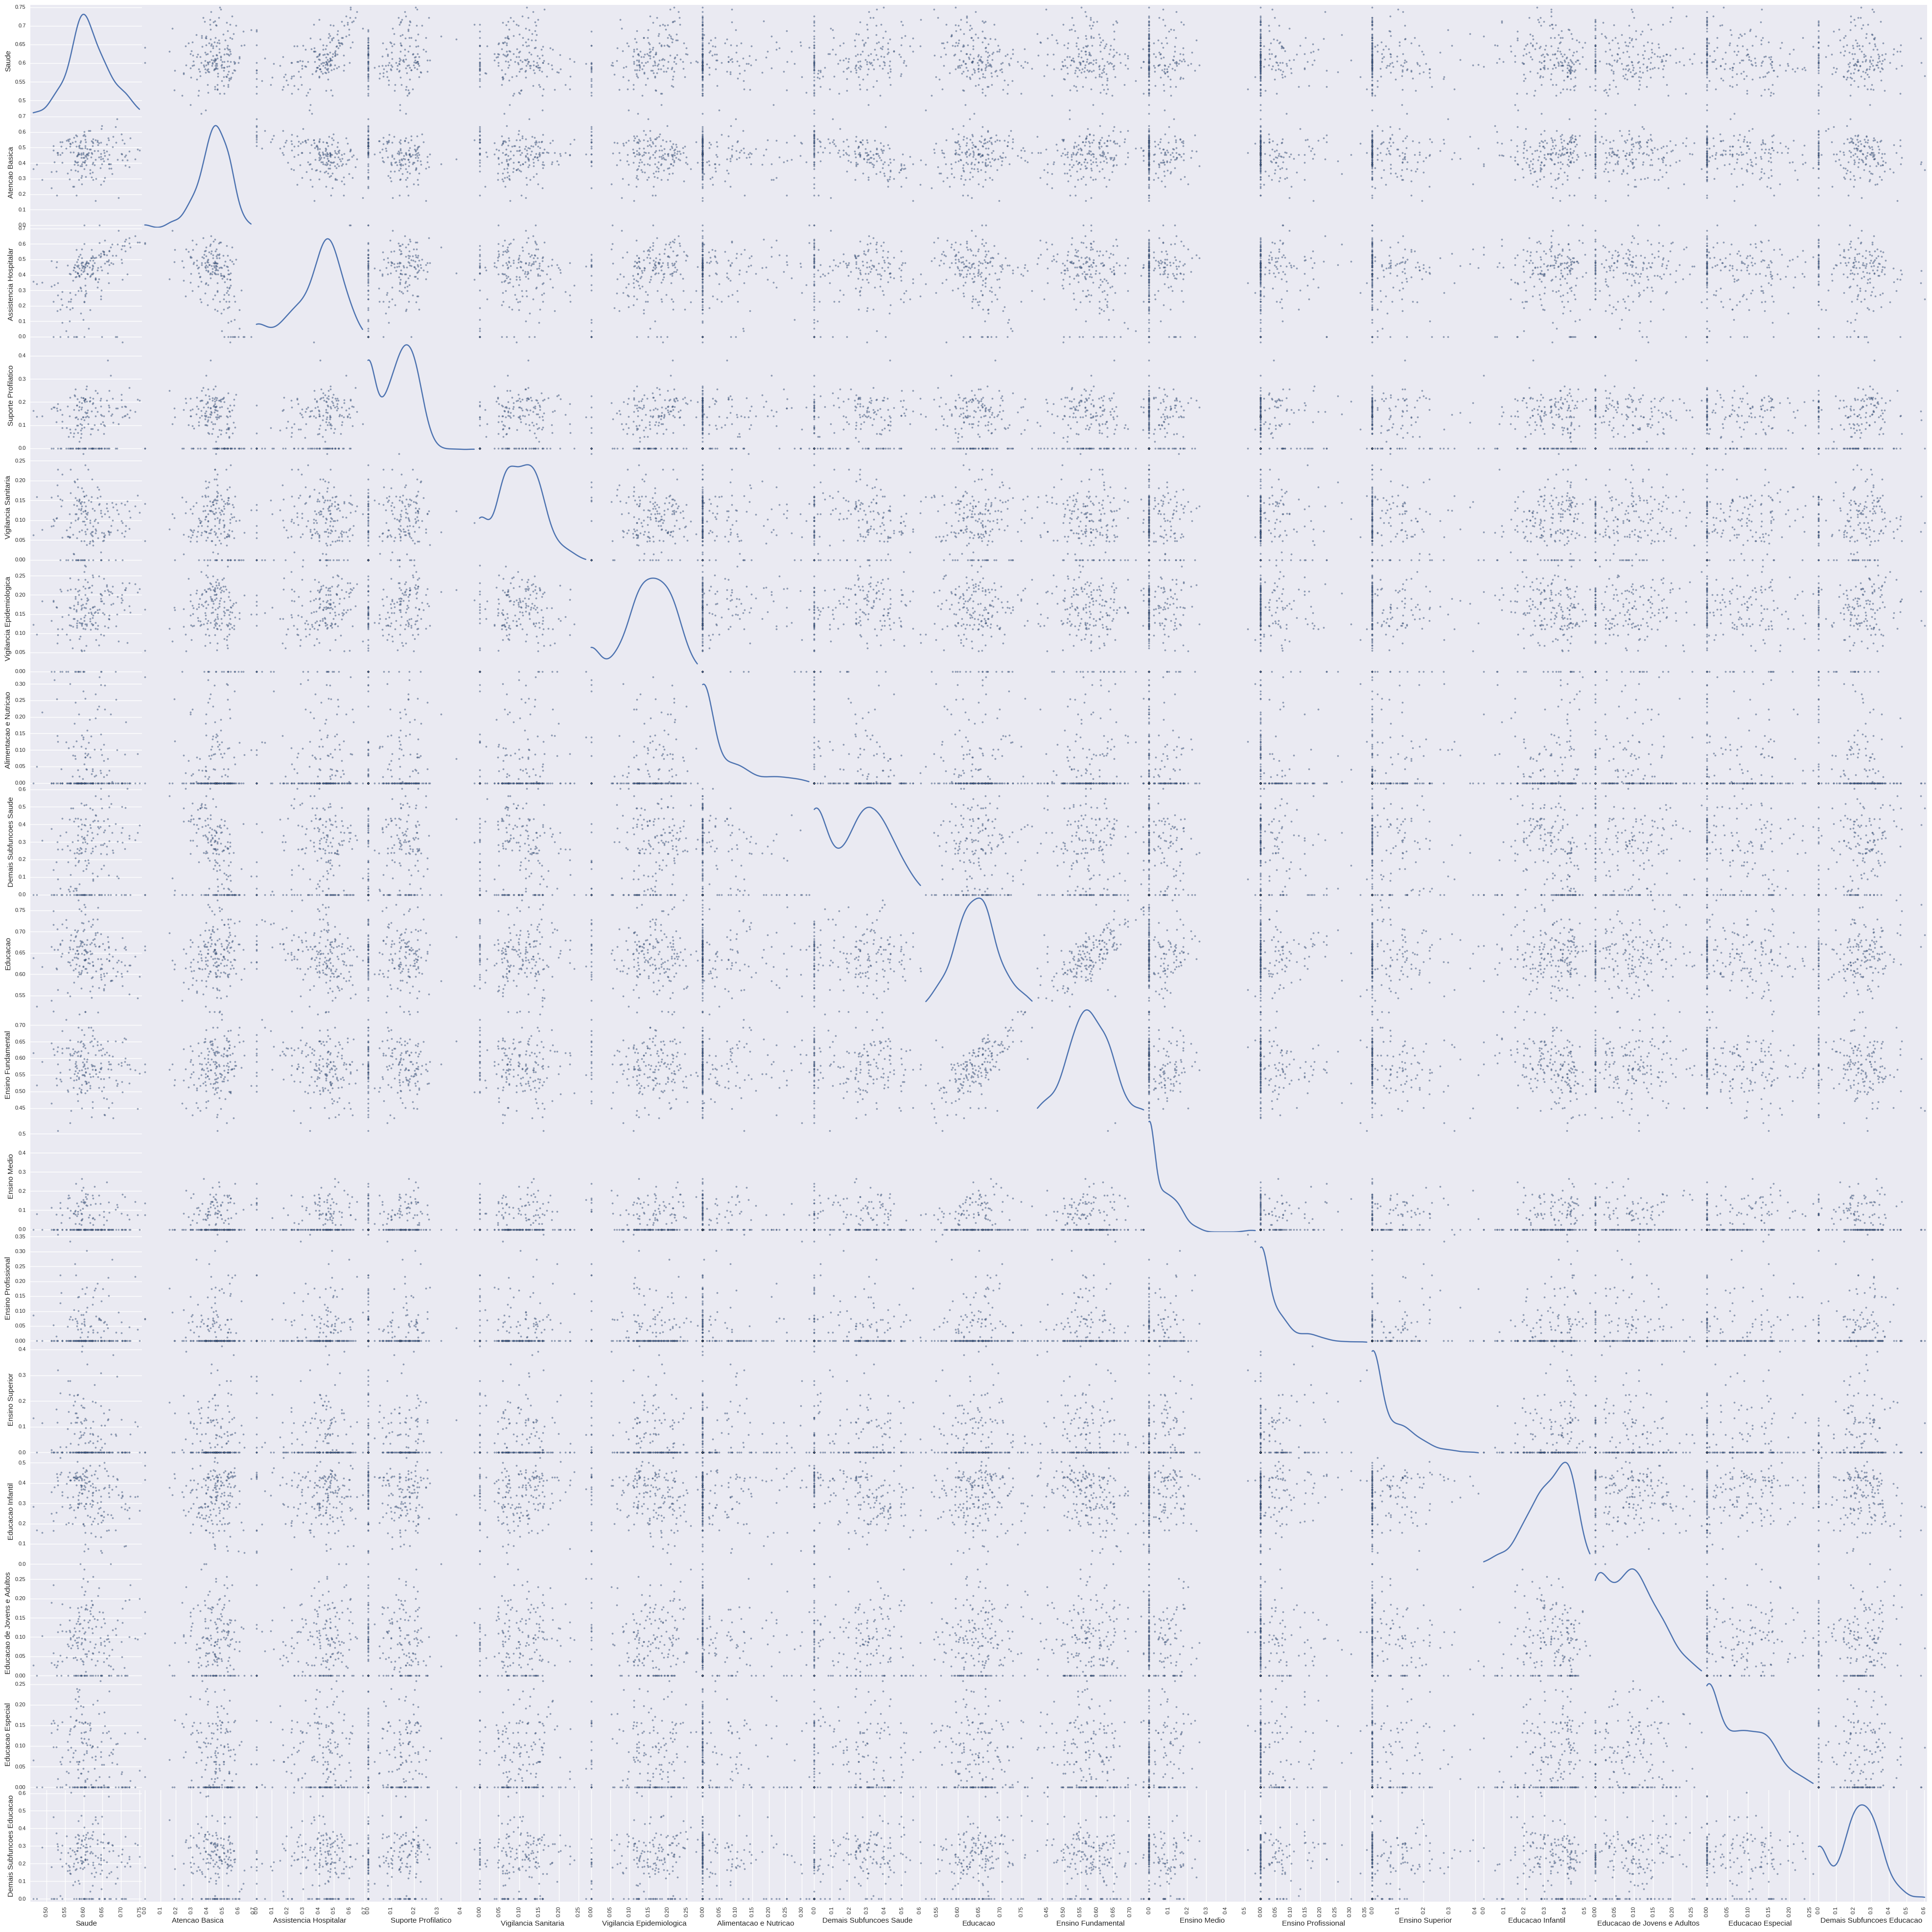

In [30]:
# Transforma os dados utilizando a raiz cubica
cbrt_gastos = gastos
cbrt_gastos = np.cbrt(gastos)

# Produz um scatterplot para cada par de features
pd.scatter_matrix(cbrt_gastos, figsize = (50,50), diagonal = 'kde');
plt.savefig('distribuicaoFeaturesTransformadas.pdf');

In [31]:
# Remove Trabalho, Educacao e Saude
cbrt_gastos.drop(['Saude', 'Educacao'], axis = 1, inplace = True)

# Agrupamentos por gastos

## Cidades medias do Brasil

In [32]:
caracteristicas_educacao = ['Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao',]
caracteristicas_saude = ['Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude']

In [33]:
# Aplica o PCA. Numero de componentes igual ao numero de colunas
def pca_fit(gastos):
    pca = PCA(n_components=len(gastos.columns))
    return pca.fit(gastos)

# Quantidade de variancia de cada componente principal
def pca_descricao(pca):
    dimensoes = range(1,len(pca.components_)+1)
    d = {'Variancia':pca.explained_variance_ratio_, 'Dimensao':dimensoes}
    componentes = pd.DataFrame(d);
    return (componentes,dimensoes)

# Cria cluster e compara mostra os silhouettes
def cluster_silhouette(n_clusters, data):
    clusterer = KMeans(n_clusters, random_state=0)
    clusterer = clusterer.fit(data)

    preds = clusterer.predict(data)

    score = silhouette_score(data, preds)

    return (score, clusterer)

### Educacao

In [34]:
gastos_edu = cbrt_gastos.loc[:,caracteristicas_educacao]
pca = pca_fit(gastos_edu)

Dimensao  Variancia
0         1   0.299866
1         2   0.240058
2         3   0.131599
3         4   0.094264
4         5   0.073737
5         6   0.064377
6         7   0.053800
7         8   0.042301

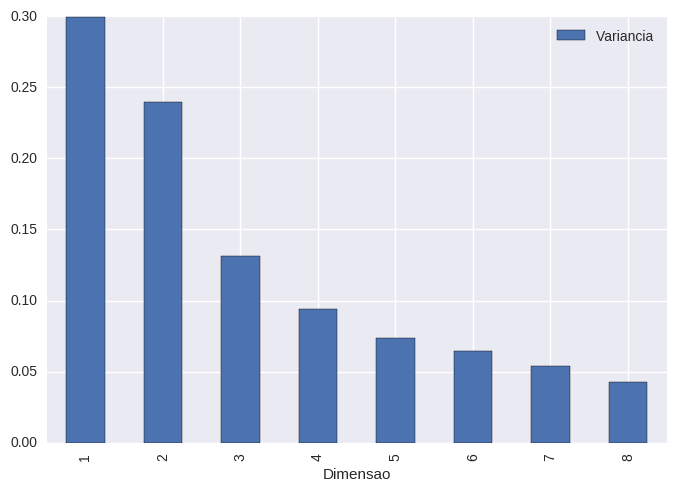

In [35]:
componentes,dimensoes = pca_descricao(pca)
display(componentes);
componentes.plot.bar(x='Dimensao',y='Variancia');
plt.savefig('Imagens/variancia_pca_educacao.pdf');

In [36]:
# Principais atributos para cada componente
atributos_por_componente = pd.DataFrame(np.round(pca.components_, 4), columns = gastos_edu.keys())
atributos_por_componente.index = dimensoes

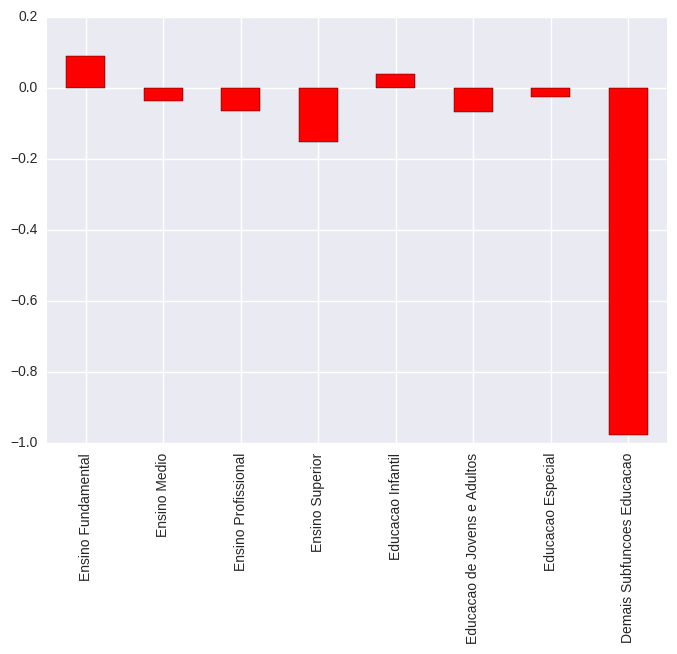

In [37]:
# Componente 1
atributos_por_componente.iloc[0,:].plot.bar(color='r');

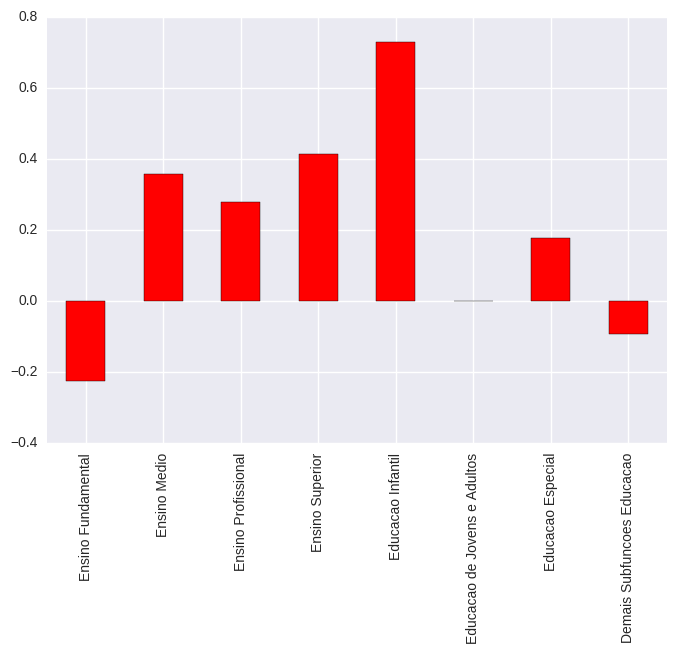

In [38]:
# Componente 2
atributos_por_componente.iloc[1,:].plot.bar(color='r');

In [39]:
# Aplica o PCA e faz o fitting dos dados utilizando quatro dimensoes
pca = PCA(n_components=2)
pca.fit(gastos_edu)

# Transforma os dados utilizando o pca
dados_reduzidos = pca.transform(gastos_edu)

# Cria um dataframe para os dados em dimensoes reduzidas
dados_reduzidos = pd.DataFrame(dados_reduzidos, columns = ['Dimension 1', 'Dimension 2'])#, 'Dimension 3', 'Dimension 4'])

In [40]:
for x in range(2, 11):
    print "number of clusters: {}, silhouette score: {}".format(x, cluster_silhouette(x, dados_reduzidos)[0])

number of clusters: 2, silhouette score: 0.389255224719
number of clusters: 3, silhouette score: 0.38201691721
number of clusters: 4, silhouette score: 0.381885919458
number of clusters: 5, silhouette score: 0.356971963364
number of clusters: 6, silhouette score: 0.347591191255
number of clusters: 7, silhouette score: 0.364078994291
number of clusters: 8, silhouette score: 0.364399699489
number of clusters: 9, silhouette score: 0.382392766786
number of clusters: 10, silhouette score: 0.392648890768


In [41]:
# Atribui cada ponto a um cluster

# Melhor cluster de acordo com silhouette
grupos = cluster_silhouette(2, dados_reduzidos)[1]

# Atribui os pontos aos clusters
preds = grupos.predict(dados_reduzidos)

# Acha o centro dos clusters
centros = grupos.cluster_centers_

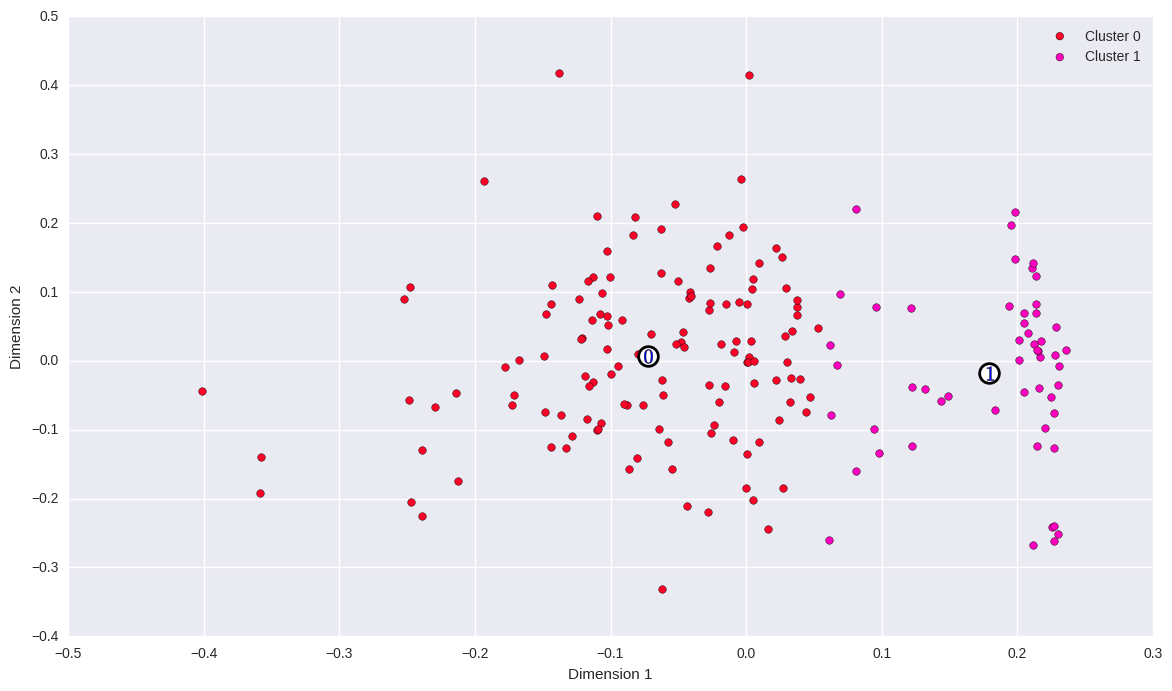

In [42]:
# Display the results of the clustering from implementation
vs.cluster_results(dados_reduzidos, preds, centros);
plt.savefig('Imagens/grupos_educacao.pdf');

In [43]:
# Adiciona cluster a tabela original de cidades
cidades_medias.insert(0, 'Grupo_educacao', preds)

### Saude 

In [44]:
gastos_saude = cbrt_gastos.loc[:,caracteristicas_saude]
pca_saude = pca_fit(gastos_saude)

Dimensao  Variancia
0         1   0.413182
1         2   0.283691
2         3   0.092923
3         4   0.079241
4         5   0.060923
5         6   0.035907
6         7   0.034133

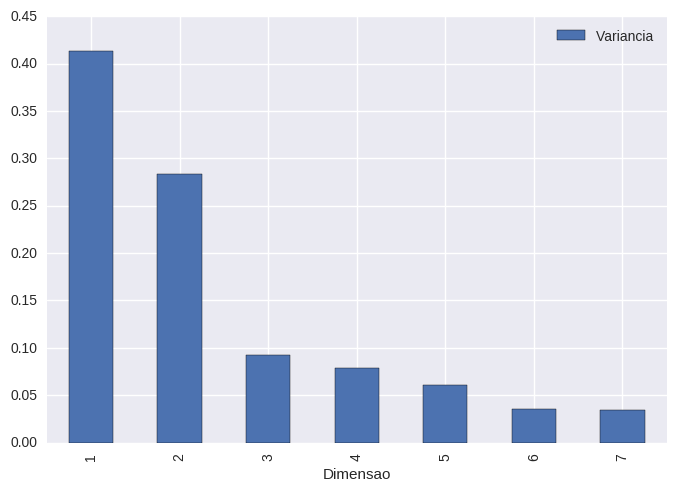

In [45]:
componentes_saude,dimensoes_saude = pca_descricao(pca_saude)
display(componentes_saude);
componentes_saude.plot.bar(x='Dimensao',y='Variancia');
plt.savefig('Imagens/variancia_pca_saude.pdf');

In [46]:
atributos_por_componente_saude = pd.DataFrame(np.round(pca_saude.components_, 4), columns = gastos_saude.keys())
atributos_por_componente_saude.index = dimensoes_saude

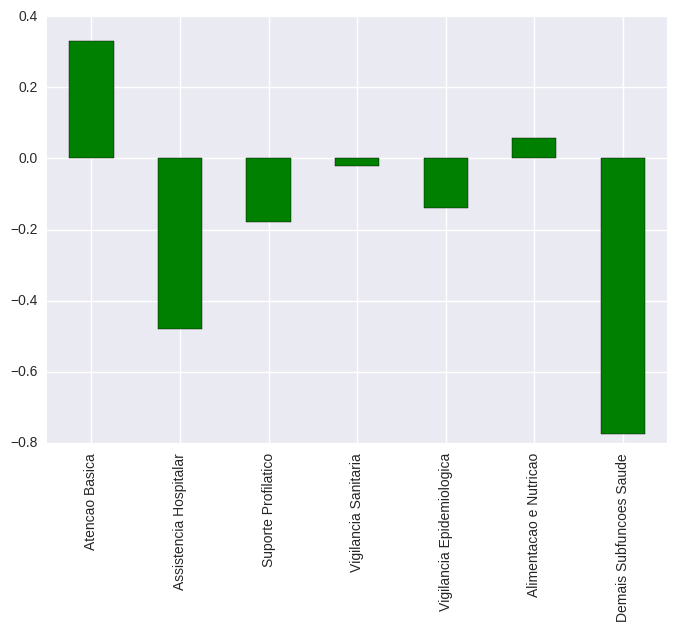

In [47]:
atributos_por_componente_saude.iloc[0,:].plot.bar(color='g');

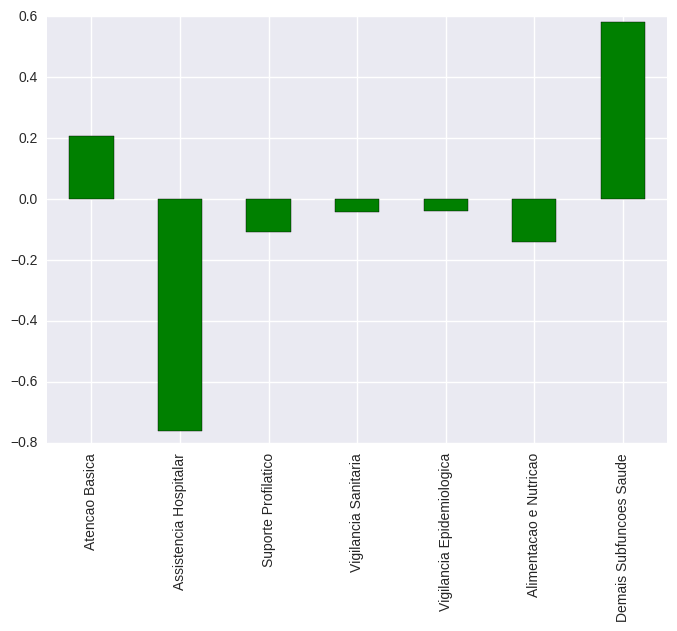

In [48]:
atributos_por_componente_saude.iloc[1,:].plot.bar(color='g');

In [49]:
pca_saude = PCA(n_components=2)
pca_saude.fit(gastos_saude)

# Transforma os dados utilizando o pca
dados_reduzidos_saude = pca_saude.transform(gastos_saude)

# Cria um dataframe para os dados em dimensoes reduzidas
dados_reduzidos_saude = pd.DataFrame(dados_reduzidos_saude, columns = ['Dimension 1', 'Dimension 2'])

In [50]:
for x in range(2, 11):
    print "number of clusters: {}, silhouette score: {}".format(x, cluster_silhouette(x, dados_reduzidos_saude)[0])

number of clusters: 2, silhouette score: 0.423484544926
number of clusters: 3, silhouette score: 0.449141266429
number of clusters: 4, silhouette score: 0.389433623633
number of clusters: 5, silhouette score: 0.414834857501
number of clusters: 6, silhouette score: 0.408461517414
number of clusters: 7, silhouette score: 0.382500410589
number of clusters: 8, silhouette score: 0.382876975573
number of clusters: 9, silhouette score: 0.391720700844
number of clusters: 10, silhouette score: 0.402269733459


In [51]:
# Melhor cluster de acordo com silhouette
grupos_saude = cluster_silhouette(3, dados_reduzidos_saude)[1]

# Atribui os pontos aos clusters
preds_saude = grupos_saude.predict(dados_reduzidos_saude)

# Acha o centro dos clusters
centros_saude = grupos_saude.cluster_centers_

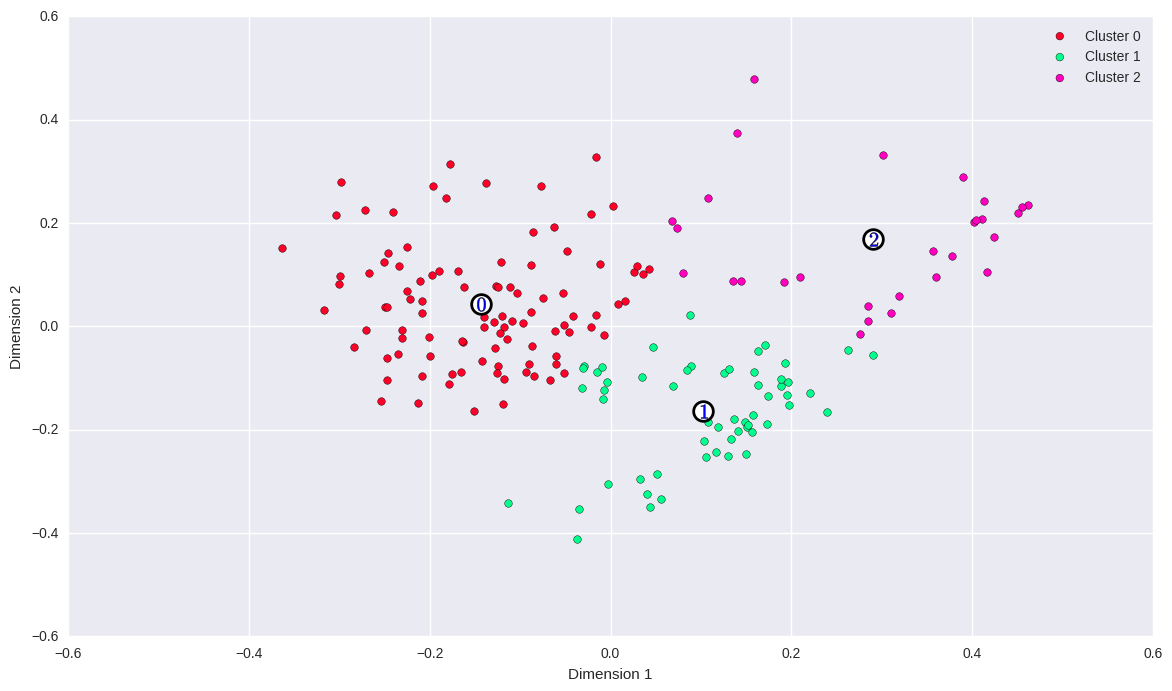

In [52]:
vs.cluster_results(dados_reduzidos_saude, preds_saude, centros_saude);
plt.savefig('Imagens/grupos_saude.pdf');

In [53]:
# Adiciona cluster a tabela original de cidades
cidades_medias.insert(0, 'Grupo_saude', preds_saude)

## Analise de grupos

### Descricao dos grupos

In [54]:
# Analise de ifdm
cidade_ifdm_grupo = cidades_medias.loc[:,['ifdm_dif_saude',
 'ifdm_dif_educacao',
 'Regiao',
 'UF', 'Municipio',
 'Grupo_educacao', 'Grupo_saude']]

cidade_ifdm_dif_grupo = cidades_medias.loc[:,['2012_saude_nota',
 '2012_educacao_nota',
 'Regiao',
 'UF', 'Municipio',
 'Grupo_educacao', 'Grupo_saude']]


In [55]:
# Cria grafico de barras com legendas por fora da figura
def grafico_barras(df, titulo):
    f = plt.figure()
    plt.title(titulo)
    df.plot(kind='bar', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Tamanho das cidades dos grupos
def n_cidades_grupos(x):
    tam_grupo = cidades_medias.loc[:,['Tamanho',x]]
    for grupo in tam_grupo[x].unique():
        print "Grupo: {}".format(grupo);
        display(tam_grupo[tam_grupo[x] == grupo].Tamanho.value_counts());

def pontos_medios(caracteristicas, area):
    x = np.append(caracteristicas, area)
    grupo = cidades_medias.loc[:,x]
    centroides = grupo.groupby(area).mean();
    return centroides

def ifdm_dif(area, metrica):
    ifdm_grupos = cidade_ifdm_grupo.groupby(area)[metrica].mean();
    display(ifdm_grupos);
    grafico_barras(ifdm_grupos, "Diferenca IFDM medio no periodo 2008-2012");

def gastos_total_area(area,g_area):
    grupo = cidades_medias.loc[:,[area,g_area]]
    gastos_grupo = grupo.groupby(area).mean();
    display(gastos_grupo);
    
    grafico_barras(gastos_grupo, "Gastos Grandes Areas");
    
# Busca centroides reais
def centroides_reais(pca, data, centros):
    # Transformacao invesa
    centros_reais_cbrt = pca.inverse_transform(centros)
    centros_reais = np.power(centros_reais_cbrt,3)

    # Display the true centers
    segments = ['Centroide {}'.format(i) for i in range(0,len(centros_reais))]
    centros_reais = pd.DataFrame(centros_reais, columns = data.keys())
    centros_reais.index = segments
    return centros_reais

def grafico_correlacao(x, y, area, grupo):
    df = cidades_medias.loc[cidades_medias[area] == grupo,[x,y]]
    
    g = sns.JointGrid(x, y, data=df)
    g = g.plot_joint(plt.scatter, color="m", edgecolor="white")
    _ = g.ax_marg_x.hist(cidades_medias[x], color="b")
    _ = g.ax_marg_y.hist(cidades_medias[y], color="r", orientation="horizontal")
    g = g.annotate(stats.pearsonr)

### Educacao

In [56]:
n_cidades_grupos("Grupo_educacao")

Grupo: 1


Media    53
Name: Tamanho, dtype: int64

Grupo: 0


Media    131
Name: Tamanho, dtype: int64

Ensino Fundamental  Ensino Medio  Ensino Profissional  \
Grupo_educacao                                                          
0                         0.195592      0.003618             0.001616   
1                         0.210083      0.000820             0.001023   

                Ensino Superior  Educacao Infantil  \
Grupo_educacao                                       
0                      0.004168           0.045123   
1                      0.000322           0.044701   

                Educacao de Jovens e Adultos  Educacao Especial  \
Grupo_educacao                                                    
0                                   0.002217           0.001653   
1                                   0.001848           0.001604   

                Demais Subfuncoes Educacao  
Grupo_educacao                              
0                                 0.029978  
1                                 0.000565

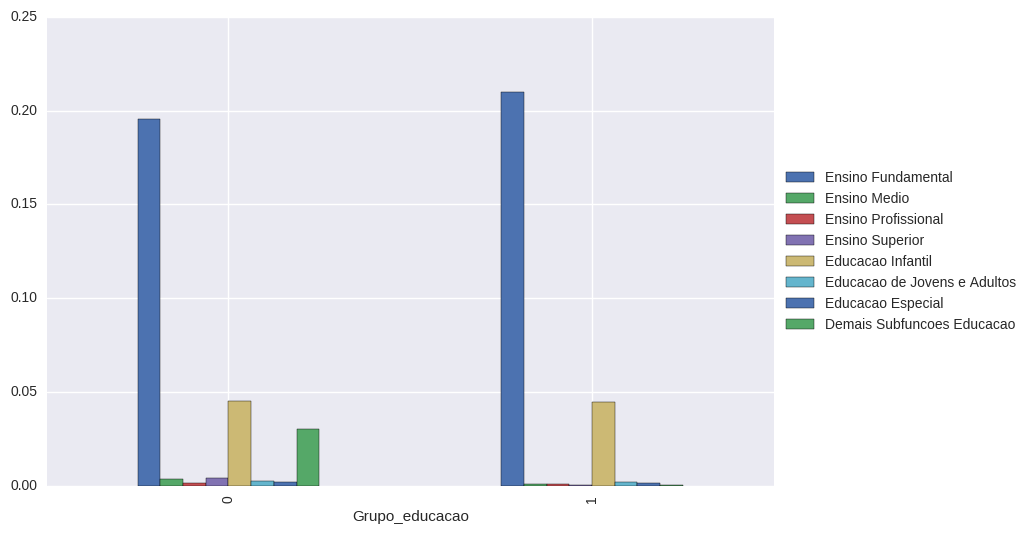

In [57]:
# Gastos das cidades em educacao
centroides_educacao = pontos_medios(caracteristicas_educacao, "Grupo_educacao")
display(centroides_educacao)   
grafico_barras(centroides_educacao, "");
plt.tight_layout()
plt.savefig('Imagens/subgrupos_educacao.pdf', bbox_inches='tight');

Grupo_educacao
0    0.075998
1    0.075687
Name: ifdm_dif_educacao, dtype: float64

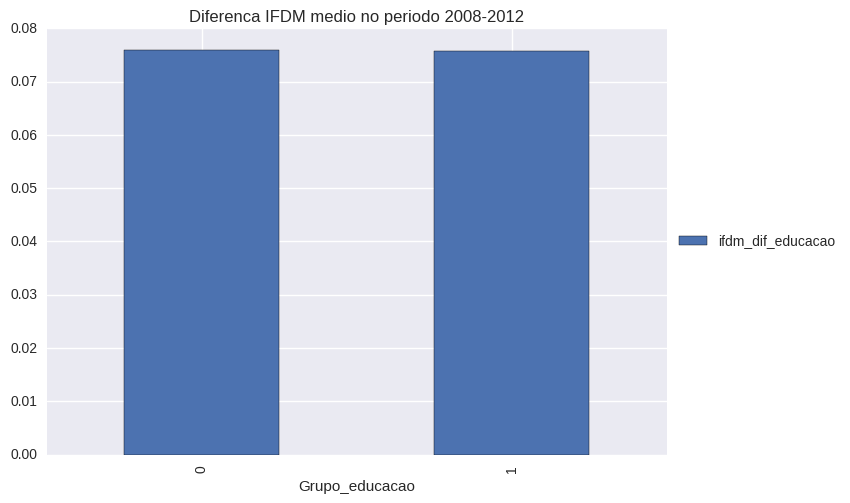

In [58]:
ifdm_dif("Grupo_educacao","ifdm_dif_educacao");
plt.savefig('Imagens/crescimento_ifdm_educacao.pdf');

Educacao
Grupo_educacao          
0               0.277770
1               0.260967

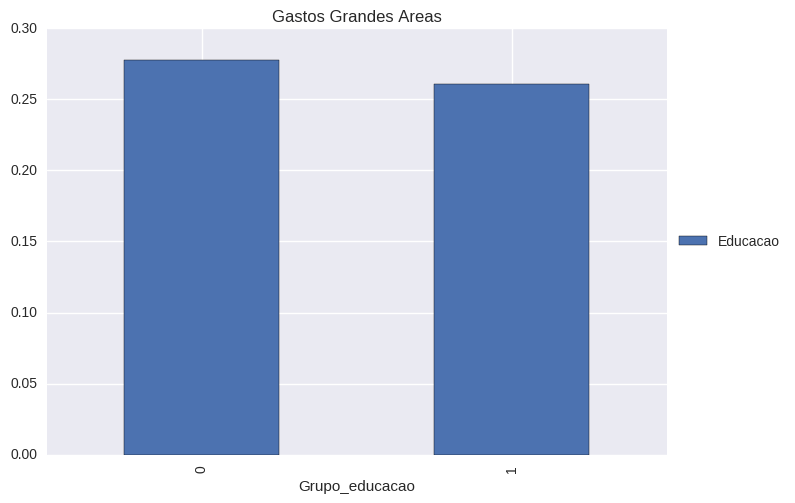

In [59]:
gastos_total_area("Grupo_educacao","Educacao")

Ensino Fundamental  Ensino Medio  Ensino Profissional  \
Centroide 0            0.184297      0.000223             0.000114   
Centroide 1            0.212919      0.000077             0.000016   

             Ensino Superior  Educacao Infantil  Educacao de Jovens e Adultos  \
Centroide 0         0.000436           0.035428                      0.000812   
Centroide 1         0.000020           0.032763                      0.000443   

             Educacao Especial  Demais Subfuncoes Educacao  
Centroide 0           0.000424                    0.022325  
Centroide 1           0.000264                    0.000054

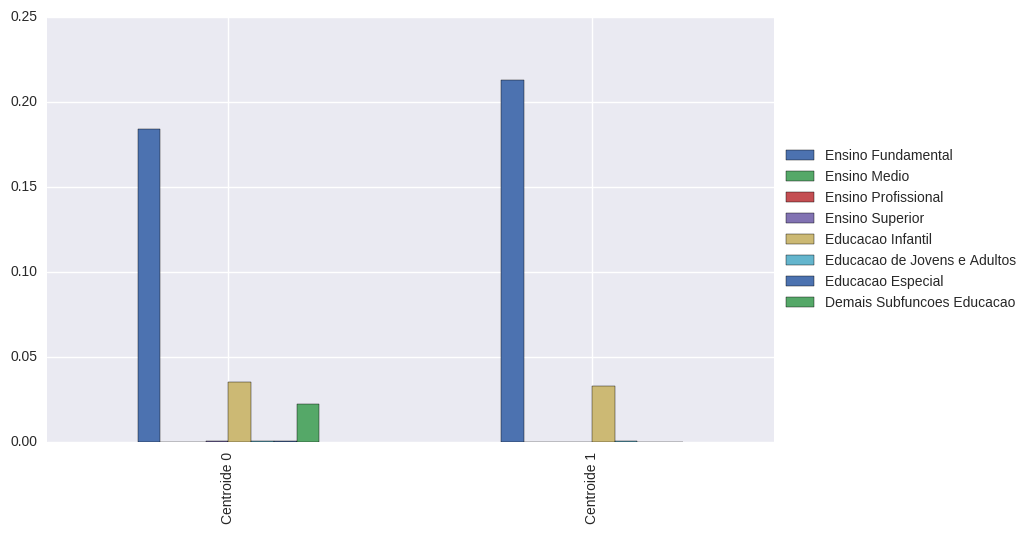

In [60]:
# centroides reais educacao
centros_reais_edu = centroides_reais(pca, gastos_edu, grupos.cluster_centers_)
display(centros_reais_edu)
grafico_barras(centros_reais_edu, "");
plt.tight_layout()
plt.savefig('Imagens/centroides_reais_educacao.pdf', bbox_inches='tight');

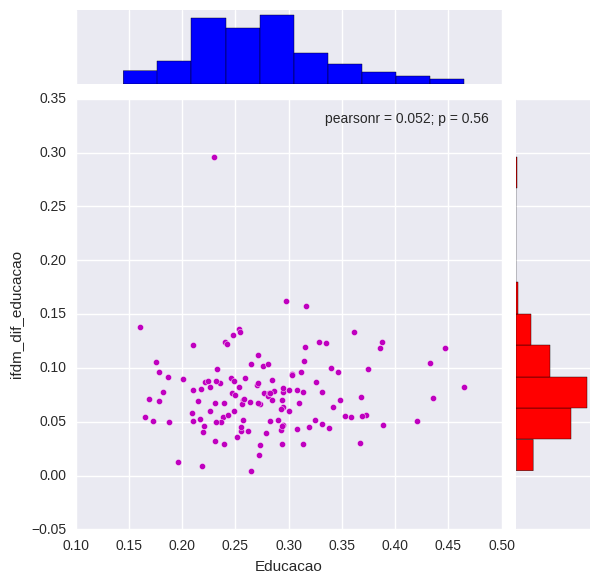

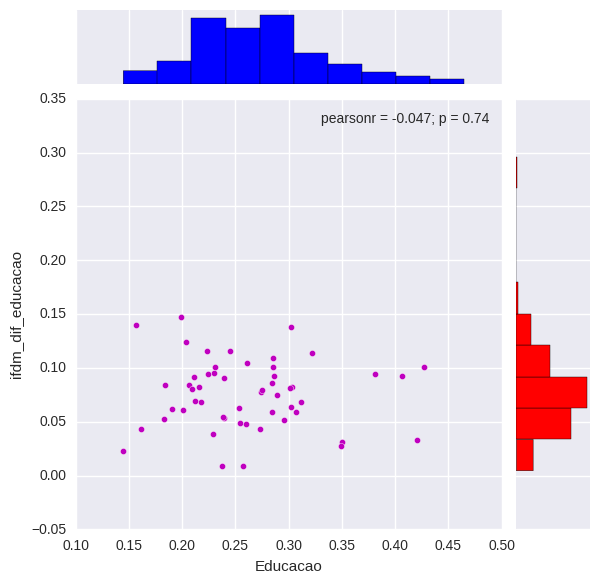

In [61]:
# Plota grafico de correlacao educacao x ifdm educacao

grafico_correlacao("Educacao", "ifdm_dif_educacao", "Grupo_educacao", 0);
grafico_correlacao("Educacao", "ifdm_dif_educacao", "Grupo_educacao", 1);

### Saude

In [62]:
n_cidades_grupos("Grupo_saude")

Grupo: 0


Media    99
Name: Tamanho, dtype: int64

Grupo: 1


Media    56
Name: Tamanho, dtype: int64

Grupo: 2


Media    29
Name: Tamanho, dtype: int64

Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
Grupo_saude                                                                
0                  0.078117                0.098472             0.005631   
1                  0.097372                0.115880             0.004510   
2                  0.179289                0.006588             0.001390   

             Vigilancia Sanitaria  Vigilancia Epidemiologica  \
Grupo_saude                                                    
0                        0.001809                   0.006218   
1                        0.002410                   0.003602   
2                        0.001632                   0.003232   

             Alimentacao e Nutricao  Demais Subfuncoes Saude  
Grupo_saude                                                   
0                          0.001146                 0.059064  
1                          0.004270                 0.001296  
2                          0.001087                 0.007399

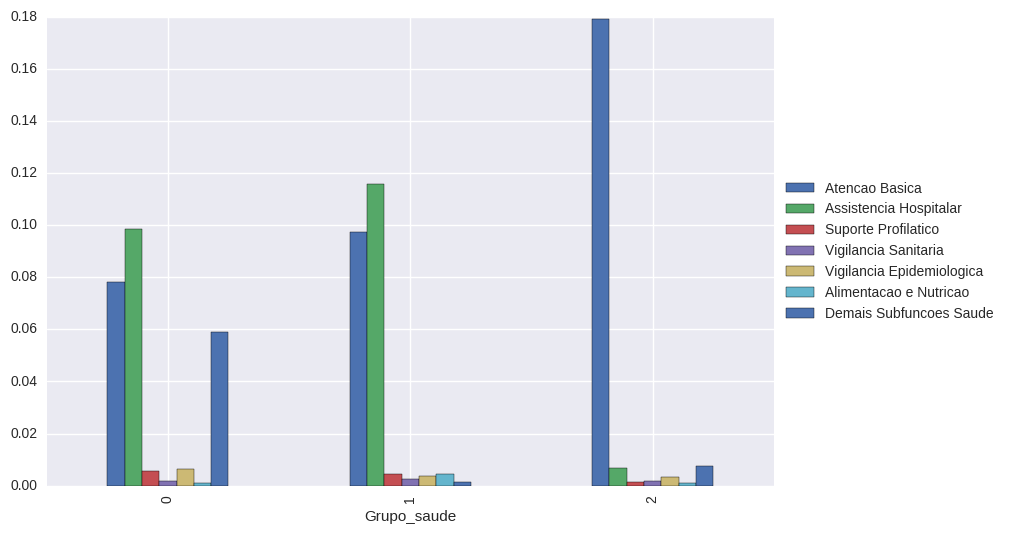

In [63]:
# Gastos das cidades em saude
centroides_saude = pontos_medios(caracteristicas_saude, "Grupo_saude")
display(centroides_saude)   
grafico_barras(centroides_saude, "");
plt.tight_layout()
plt.savefig('Imagens/subgrupos_saude.pdf', bbox_inches='tight');

Grupo_saude
0    0.035090
1    0.039652
2    0.025393
Name: ifdm_dif_saude, dtype: float64

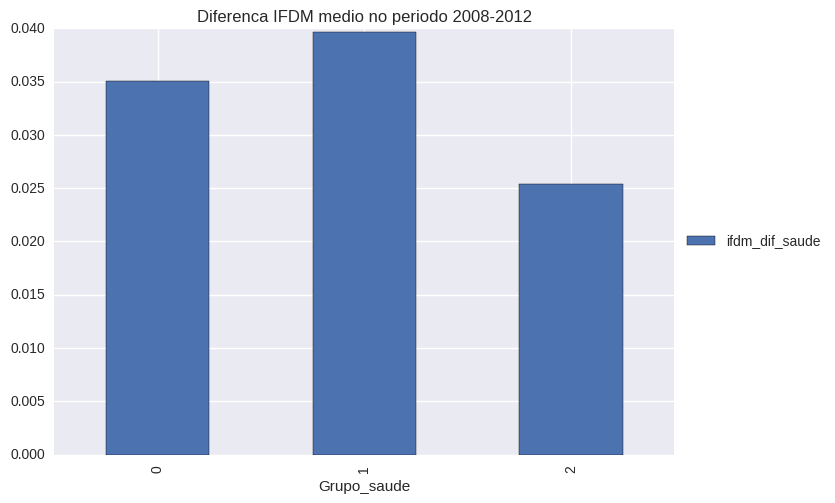

In [64]:
ifdm_dif('Grupo_saude', "ifdm_dif_saude");
plt.savefig('Imagens/crescimento_ifdm_saude.pdf');

Saude
Grupo_saude          
0            0.250456
1            0.228950
2            0.200618

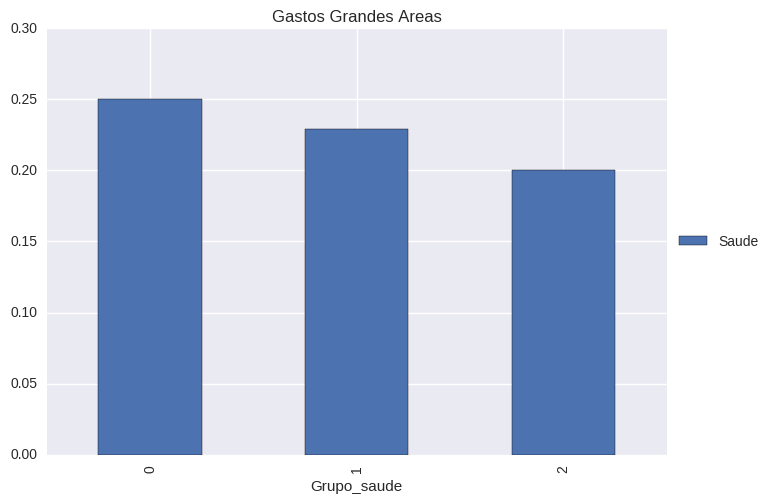

In [65]:
gastos_total_area("Grupo_saude","Saude")

Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
Centroide 0        0.065893                0.082277             0.002592   
Centroide 1        0.086407                0.107451             0.001563   
Centroide 2        0.188838                0.002277             0.000103   

             Vigilancia Sanitaria  Vigilancia Epidemiologica  \
Centroide 0              0.000982                   0.004523   
Centroide 1              0.001091                   0.002701   
Centroide 2              0.000604                   0.000991   

             Alimentacao e Nutricao  Demais Subfuncoes Saude  
Centroide 0                0.000047                 0.048198  
Centroide 1                0.000506                 0.000138  
Centroide 2                0.000080                 0.001016

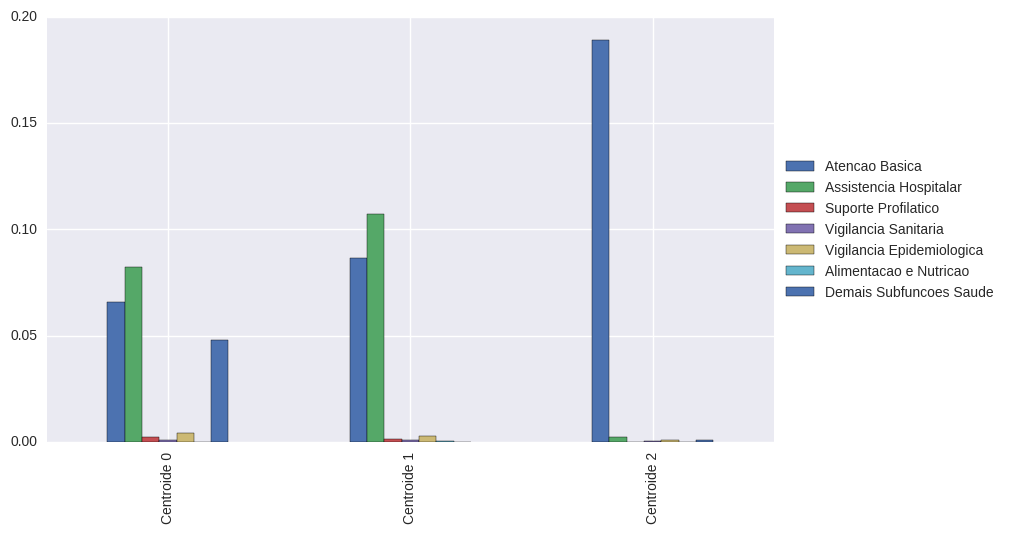

In [66]:
# centroides reais saude
centros_reais_saude = centroides_reais(pca_saude, gastos_saude, grupos_saude.cluster_centers_);
display(centros_reais_saude);
grafico_barras(centros_reais_saude, "");
plt.tight_layout()
plt.savefig('Imagens/centroides_reais_saude.pdf', bbox_inches='tight');

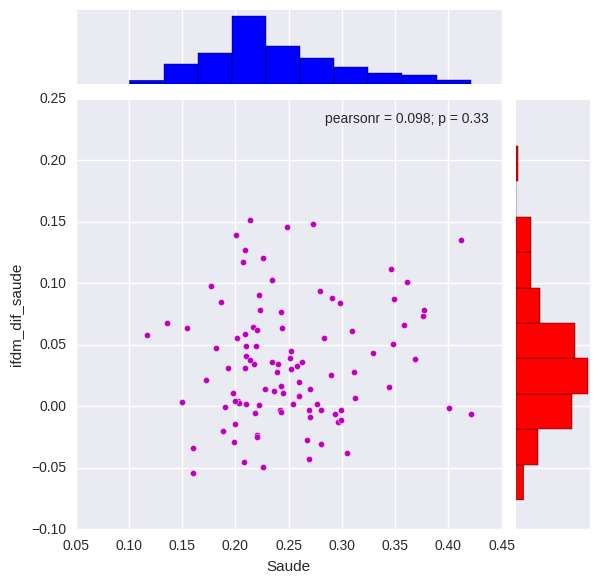

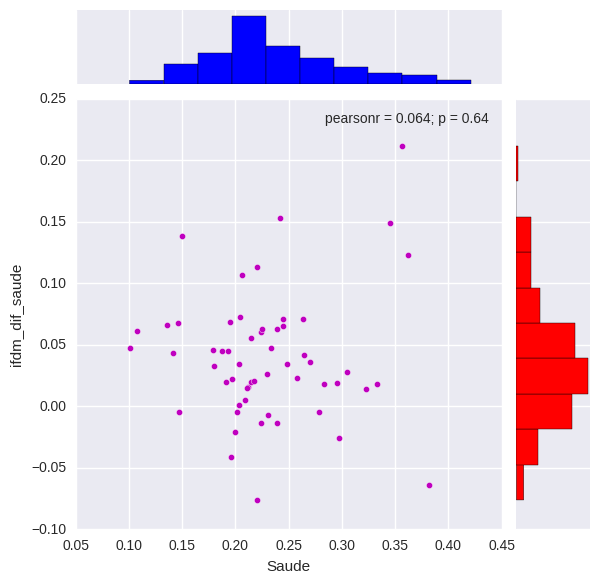

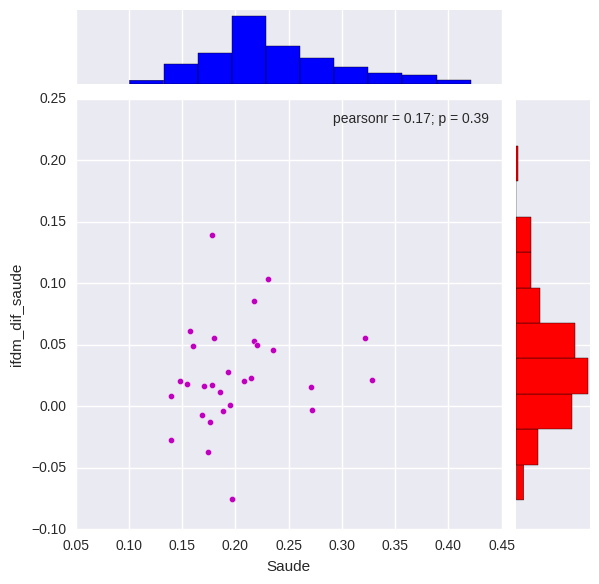

In [67]:
# Plota grafico de correlacao saude x ifdm

grafico_correlacao("Saude", "ifdm_dif_saude", "Grupo_saude", 0);
grafico_correlacao("Saude", "ifdm_dif_saude", "Grupo_saude", 1);
grafico_correlacao("Saude", "ifdm_dif_saude", "Grupo_saude", 2);

### Descrição dos representantes dos grupos

In [68]:
# retorna o maior valor de uma feature e a cidade que a detem
def maior_valor(x, col):
    max_value = x[col].max()
    mun = x[x[col] == max_value].loc[:,["UF","Municipio"]]
    mun["Crescimento"] = max_value
    return mun

In [69]:
# Busca cidades destaque em cada grupo

# Maior ganho em saude
print "Cidades que mais cresceram em Saude: "
display(cidades_medias.groupby("Grupo_saude").apply(maior_valor, "ifdm_dif_saude"));
    
# Maior ganho em educacao
print "Cidades que mais cresceram em educacao: "
display(cidades_medias.groupby("Grupo_educacao").apply(maior_valor, "ifdm_dif_educacao"));

Cidades que mais cresceram em Saude: 


UF           Municipio  Crescimento
Grupo_saude                                          
0           2822  SP        praia grande       0.1517
1           1406  BA           barreiras       0.2117
2           1850  MG  coronel fabriciano       0.1397

Cidades que mais cresceram em educacao: 


UF      Municipio  Crescimento
Grupo_educacao                                     
0              1432  BA       camacari       0.2960
1              3100  PR  foz do iguacu       0.1474

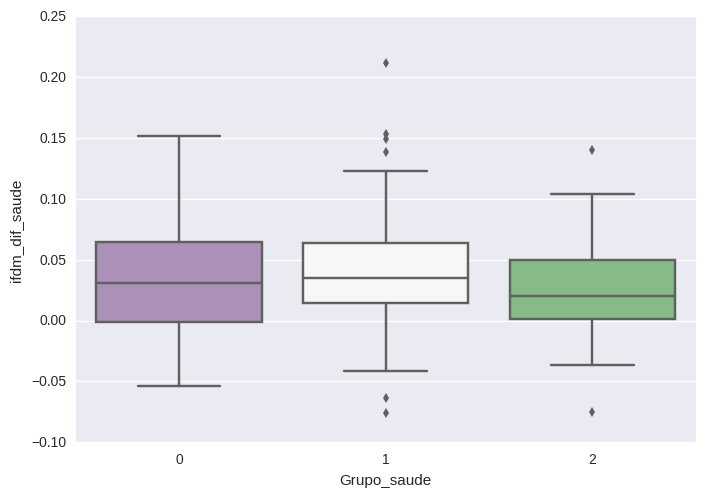

In [70]:
# Boxplot crescimento das cidades em saude por grupos no periodo de 2009 a 2012
sns.boxplot(data=cidades_medias, x="Grupo_saude", y="ifdm_dif_saude", palette="PRGn");
plt.savefig('Imagens/boxplots_ifdm_saude.pdf');

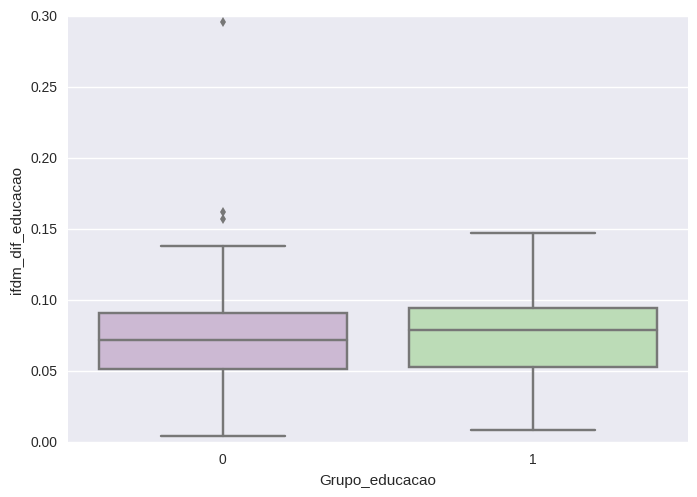

In [71]:
# Boxplot crescimento das cidades em educacao por grupos no periodo de 2009 a 2012
sns.boxplot(data=cidades_medias, x="Grupo_educacao", y="ifdm_dif_educacao", palette="PRGn");
plt.savefig('Imagens/boxplots_ifdm_educacao.pdf');